In [1]:
import os
print(os.getcwd())


/


In [3]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=1be70fb76c51bc0f2d18525571d16ff1820f7b1d30988fd5a545fb531eed71b7
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle


In [4]:
!mkdir -p ~/.kaggle
!mv /path/to/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat '/path/to/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
'''
Task 1
Fetch MQTTset from Kaggle
'''
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = 'cnrieiit/mqttset'
api.dataset_download_files(dataset, path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/cnrieiit/mqttset


In [2]:
import pyspark
from pyspark.sql import SparkSession

try:
    spark = SparkSession.getActiveSession()
    if spark is None:
        print("No active SparkSession found.")
    else:
        print("An active SparkSession is running.")
except Exception as e:
    print("Error checking SparkSession:", e)


No active SparkSession found.


In [82]:
print("help")

help


In [3]:
'''
Task 1
Setup SparkSession and test connection to Postgres
'''
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit 


# Define dataset, spark constants
APPNAME = 'Roberts_Systool_Project'
MASTER = 'yarn'
# JDBC_JAR_PATH = '/home/jroberts1187/course-project-option-2-aitechroberts/postgresql-42.7.4.jar'
JDBC_JAR_PATHS = [
    "/home/jroberts1187/course-project-option-2-aitechroberts/postgresql-42.7.4.jar",
    "/home/jroberts1187/course-project-option-2-aitechroberts/postgres-socket-factory-1.21.0.jar",
    "/home/jroberts1187/course-project-option-2-aitechroberts/google-api-client-1.33.0.jar",
    "/home/jroberts1187/course-project-option-2-aitechroberts/google-oauth-client-1.33.1.jar",
    "/home/jroberts1187/course-project-option-2-aitechroberts/google-http-client-1.39.2.jar"
]
# JDBC_URL = 'jdbc:postgresql://104.196.99.150:5432/projectdb' CloudSQL URL
'''
Point all nodes (master and workers) to local host to run through each of their own CloudSQL Proxies
'''
JDBC_URL = 'jdbc:postgresql://127.0.0.1:5432/postgres'
DB_PROPERTIES = {
    "user": "postgres",
    "password": "postgres_pw",
    "driver": "org.postgresql.Driver",
    # 'ssl': 'true',
    # 'sslmode': 'require',
    "batchsize": "10000" # trying to optimize the write and seems to have cut the time in half
}

# Initialize Spark session with PostgreSQL JDBC driver
spark = SparkSession.builder \
    .appName(APPNAME) \
    .master(MASTER) \
    .config('spark.jars',  ",".join(JDBC_JAR_PATHS)) \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .getOrCreate()

# Local Spark Configuration
# # Initialize Spark session with PostgreSQL JDBC driver
# spark = SparkSession.builder \
#     .appName(APPNAME) \
#     .master(MASTER)\
#     .config('spark.driver.host','127.0.0.1')\  
#     .config("spark.jars", JDBC_JAR_PATH) \
#     .config("spark.driver.memory", "4g") \  
#     .config("spark.executor.memory", "3g") \
#     .getOrCreate()

# df = spark.read.jdbc(url=JDBC_URL, table="mqtt", properties=DB_PROPERTIES)
# df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/11 19:55:53 INFO SparkEnv: Registering MapOutputTracker
24/11/11 19:55:53 INFO SparkEnv: Registering BlockManagerMaster
24/11/11 19:55:53 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/11/11 19:55:53 INFO SparkEnv: Registering OutputCommitCoordinator


In [127]:
spark.stop()

ConnectionRefusedError: [Errno 111] Connection refused

In [4]:
simple_df = spark.range(1000)
simple_df.show(5)


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



In [6]:
JDBC_URL = 'jdbc:postgresql://127.0.0.1:5432/postgres'
# Add the JAR to the current SparkSession
DB_PROPERTIES = {
    "user": "postgres",
    "password": "postgres_pw",
    "driver": "org.postgresql.Driver",
    "connectTimeout": "10",
    # 'ssl': 'true',
    # 'sslmode': 'require',
    # "socketFactory": "com.google.cloud.sql.postgres.SocketFactory",
    # "cloudSqlInstance": "systool-436201:us-east1:projectdb",
    "batchsize": "10000" # trying to optimize the write and seems to have cut the time in half in local
}

try:
    df = spark.read.jdbc(url=JDBC_URL, table='test', properties=DB_PROPERTIES)
    df.show()  # This should display a single row with "3" if the connection is successful
    print("Connection to PostgreSQL database successful!")
except Exception as e:
    print("Failed to connect to PostgreSQL database:", e)

+---+
|val|
+---+
|  3|
+---+

Connection to PostgreSQL database successful!


In [95]:
'''
Task 1
Ingest data with Spark and write to Postgres

Creates a dictionary for data files and associated data category,
then loops over both values using .items() method

In the loop, it dynamically changes the data category and write mode
based on where the code executes in the loop. First loop overwrites
to create table and schema if not already exists. Second loop appends

Trying optimizations for fun, repartitioning with the rule of thumb of
2x the number of cores and using 3 of the 4 cores while leaving 1 for
other processes increased speed by about 55-60% from 12mins to about
5.75mins. Including batchsize of 10,000 also just about cut the time
in half from there down to right at 2 minutes and 45 seconds.
'''
import os


COL_NAMES = [
    'tcp_flags', 'tcp_time_delta', 'tcp_len', 'mqtt_conack_flags', 
    'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conack_val', 
    'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 
    'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_uname', 
    'mqtt_conflag_willflag', 'mqtt_conflags', 'mqtt_dupflag', 'mqtt_hdrflags', 
    'mqtt_kalive', 'mqtt_len', 'mqtt_msg', 'mqtt_msgid', 'mqtt_msgtype', 
    'mqtt_proto_len', 'mqtt_protoname', 'mqtt_qos', 'mqtt_retain', 
    'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_ver', 'mqtt_willmsg', 
    'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'target'
]

# LOCAL_DATA_FOLDER = "./Data/FINAL_CSV" # won't change due to mqttset zip
HDFS_DATA_FOLDER = "hdfs://cluster-15d7-m/user/hadoop/Data/FINAL_CSV"

data_files = {
    'train70_augmented.csv': 'train',
    'test30_augmented.csv': 'test'
}
overwrite = True
for file, set_type_value in data_files.items():
    # Use the 'file://' prefix to ensure Spark reads from the local file system rather than searching HDFS because I didn't put the data there.
    file_path = os.path.join(HDFS_DATA_FOLDER, file)
    
    # Read CSV file
    df = spark.read.csv(file_path, header=False, inferSchema=True).toDF(*COL_NAMES)
    
    # Add 'set_type' column and dataset value of 'train' or 'test' based on place in dictionary loop
    df = df.withColumn('set_type', lit(set_type_value))
    
    df.repartition(16)
    # Show first row for verification
    # df.show(1)
    
    # Overwrite on the first loop and append on the rest
    write_mode = 'overwrite' if overwrite else 'append'
    
    # Write data to Postgres
    df.write.jdbc(url=JDBC_URL, 
                  table="mqtt", 
                  mode=write_mode, 
                  properties=DB_PROPERTIES,
                  )
    
    # Set overwrite to False after the first write
    if overwrite:
        overwrite = False

In [ ]:
spark.stop()

In [7]:
'''
Task 2
Ingest Data from Postgres into Spark for Data Analysis
'''
num_partitions = 16 # Adjust based on your environment which is 8 cores on Dataproc currently
mqtt_df = spark.read.jdbc(url=JDBC_URL,
                          table="mqtt",
                          properties=DB_PROPERTIES,
                          numPartitions=num_partitions,
                          )


In [99]:
# Number of rows
num_rows = mqtt_df.count()

# Number of columns
num_cols = len(mqtt_df.columns)

print(f"Shape: {num_rows}, {num_cols}")

Shape: 20000002, 35


In [100]:
mqtt_df.printSchema()

# print target col values
# mqtt_df.select("target").distinct().show(truncate=False)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: string (nullable = true)
 |-- tcp_len: string (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: string (nullable = true)
 |-- mqtt_conack_flags_sp: string (nullable = true)
 |-- mqtt_conack_val: string (nullable = true)
 |-- mqtt_conflag_cleansess: string (nullable = true)
 |-- mqtt_conflag_passwd: string (nullable = true)
 |-- mqtt_conflag_qos: string (nullable = true)
 |-- mqtt_conflag_reserved: string (nullable = true)
 |-- mqtt_conflag_retain: string (nullable = true)
 |-- mqtt_conflag_uname: string (nullable = true)
 |-- mqtt_conflag_willflag: string (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: string (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: string (nullable = true)
 |-- mqtt_len: string (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: string (nullable = true)
 |--

In [104]:
'''
Task 2 
1. Find the average length of an MQTT message captured in
the training dataset for a given target X?

Also trying to use best practices in defining functions for employers
Most analytics will be on the test set when possible to limit processing
when possible and should be large enough, but data engineering will require the whole dataset
'''
from pyspark.sql.functions import col, avg, length


def get_average_len(df, type_set='train', target=None):
    '''
    Function filters the dataset as much as possible using input parameters
    then aggregates the average mqtt message length and returns that integer value

    :param set: 'train' or 'test' in mqtt_df
    :param target: 'slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'
    
    return: int
    '''
    if type_set not in ('test', 'train'):
        raise ValueError("set parameter must be 'train' or 'test'")
    elif target not in ('slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'):
        raise ValueError("target parameter must be one of these: 'slowite', 'bruteforce', 'flood', 'malformed', 'dos', 'legitimate'")
    
    '''
    I think it would be get to .cache() and unpersist(), but I'm afraid I'll break local memory
    so I'll also filter and select to make dataframe as small as possible beforehand
    '''
    len_df = df.filter((col('set_type') == type_set) & (col('target') == target)).select('mqtt_msg').cache()
    
    # get the right column, then len of values in column, then average, all in an aggregate Spark action method, and .agg() requires .alias()
    avg_len = len_df.agg(avg(length(col('mqtt_msg'))).alias('average_length')).collect()
    len_df.unpersist()
    return avg_len[0]['average_length']

print(f"Average MQTT message length is: {get_average_len(mqtt_df, target='dos'):.2f}")

Average MQTT message length is: 83.76


In [117]:
'''
Task 2 
2. For each target value, 
1) what is the average length of TCP messages and 
2) what is the most popular header flags’ code (mqtt.hdrflags)?

Given the task, it seems no other parameters are necessary
'''
from pyspark.sql.functions import col, avg, length


def get_all_avg_tcp_len(df):
    '''
    Function loops over each unique value in the target column
    to add the average tcp message length to a dictionary and
    returns a dictionary with the avg tcp message length for
    each target value and that target's most popular hdrflag
    placed in a dictionary of tuples where [0]=tcp_len and
    [1]=popular_header 

    Example: {'target':(50, 'hdrflag_val')}

    return: dict
    '''
    answer = {}
    targets = [row[0] for row in mqtt_df.select('target').distinct().collect()]
    targets = targets[1:]
    # filters for tcp messages and pulls only necessary columns
    tcp_df = df.filter((col('tcp_len') != 0)  & (col('mqtt_hdrflags').isNotNull())).select('target', 'tcp_len', 'mqtt_hdrflags').cache()
    
    print(targets)
    # Loop over every unique value in target column to get avg tcp_len and top mqtt_hdrflag value
    for target in targets:
        print(target)
        # Filter by target, then get average length
        target_df = tcp_df.filter(col('target') == target).cache()
                         
        tcp_len = target_df.agg(avg(length(col('tcp_len'))).alias('average_length')).collect()
        pop_hdr = target_df.groupBy('mqtt_hdrflags').count().orderBy(col('count').desc()).first()
        
#         # If no mqtt_hdrflags were found, set a default value for pop_hdr
#         if pop_hdr:
#             hdrflag_val = pop_hdr['mqtt_hdrflags']
#         else:
#             hdrflag_val = "No hdrflags found"
        
        answer[target] = (tcp_len[0]['average_length'], pop_hdr['mqtt_hdrflags'])
        print("running through function")
        print(pop_hdr['mqtt_hdrflags'])
        print(tcp_len[0]['average_length'])
        target_df.unpersist()
    # get the right column, then len of values in column, then average, all in an aggregate Spark action method, and .agg() requires .alias()
    tcp_df.unpersist()
    return answer

ans = get_all_avg_tcp_len(mqtt_df)
keys = ans.keys()
for key in keys:
    print(f"Average TCP message length for target value {key} is: {ans[key][0]:.2f} \n and the most popular header value for {key} is: {ans[key][1]}")

24/11/11 19:35:09 WARN CacheManager: Asked to cache already cached data.        
24/11/11 19:35:09 WARN CacheManager: Asked to cache already cached data.


['malformed', 'slowite', 'bruteforce', 'legitimate', 'dos', 'flood']
malformed
running through function
0x00000030
1.7946348733233979
slowite


running through function
0
1.335095567303782
bruteforce


running through function
0x00000010
1.5
legitimate


running through function
0x00000030
1.9717988709457337
dos


running through function
0x00000040
2.418047699773572
flood


running through function
0x00000030
4.842741935483871
Average TCP message length for target value malformed is: 1.79 
 and the most popular header value for malformed is: 0x00000030
Average TCP message length for target value slowite is: 1.34 
 and the most popular header value for slowite is: 0
Average TCP message length for target value bruteforce is: 1.50 
 and the most popular header value for bruteforce is: 0x00000010
Average TCP message length for target value legitimate is: 1.97 
 and the most popular header value for legitimate is: 0x00000030
Average TCP message length for target value dos is: 2.42 
 and the most popular header value for dos is: 0x00000040
Average TCP message length for target value flood is: 4.84 
 and the most popular header value for flood is: 0x00000030


In [118]:
'''
3. What is the most frequent X TCP flags for traffic with TCP time delta that is smaller than or equal to Y.
- [] X represents a positive integer. Handle scenarios where a user may send
negative values to your function.
- [] Y represents a float value between 0.0 and 5.0.
- [] Make sure to handle this scenario as well: if the user requests 5 most frequent TCP flags but there are 3 Flags that share the same count at rank number 5, please include all of them in your output.

Believing that most frequent X means top X(int) TCP Flags and ranks were not asked for, funtion returns a list of flags
'''

def get_most_frequent_flags(df, X: int, Y: float):
    '''
    Function filters for tcp_flags and tcp_time_delta to minimize data
    for processing. Handles errors by raisng ValueErrors and includes rank
    ties as they appear.

    return: list
    '''
    if 0 >= X:
        raise ValueError("X must be a positive integer.")
    if not (5.0 >= Y >= 0.0):
        raise ValueError("Y must be a float between 0.0 and 5.0.")
    
    # Filter by tcp_time_delta less than Y, then count values in tcp_flags and collect rows
    flags_df = df.filter(col('tcp_time_delta') <= Y).select('tcp_flags')
    desc_flags = flags_df.groupBy('tcp_flags').count().orderBy(col('count').desc()).collect()

    top_flags = []
    for i, row in enumerate(desc_flags):
        # Continue until X int is reached or if the previous row count equals the current row counts to add ties
        if X > i or row['count'] == desc_flags[i - 1]['count']:
            top_flags.append(row['tcp_flags'])
    return top_flags

flags = get_most_frequent_flags(mqtt_df, X=4, Y=.003)
print('The most frequent flags for tcp_time_delta < Y are:')
for flag in flags:
    print(f'{flag}') 

The most frequenXt flags for tcp_time_delta < Y are:
0x00000010
0x00000018
0x00000002
0x00000011


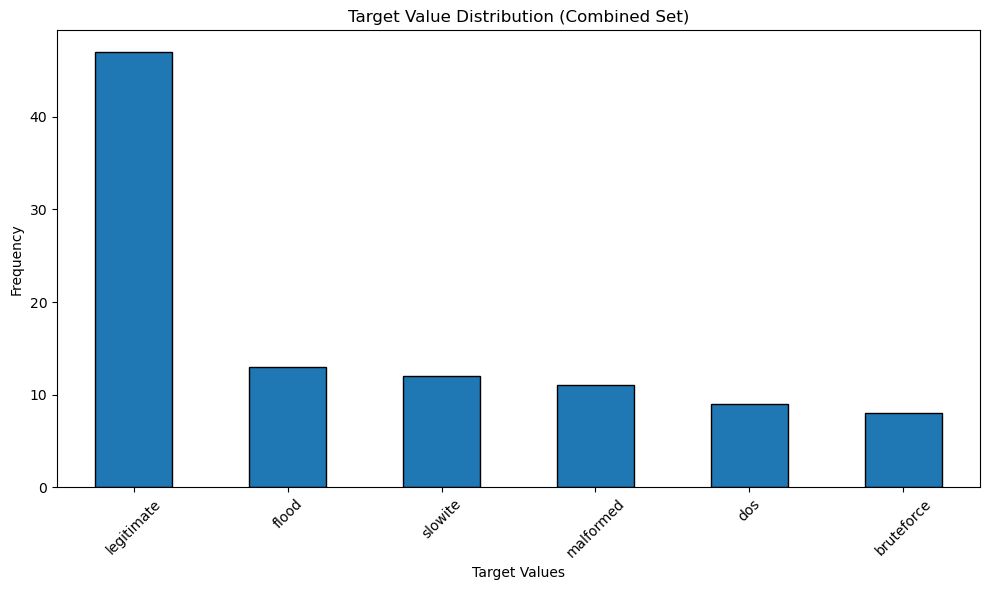

In [10]:
'''
4. Show a histogram for the target values in the training, testing or combined
dataset.
- [] Your code should accept an argument that defines if the histogram is
shown for the training, testing or combined.
'''
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, avg, length


def create_target_hist(df, set_type='test'):
    '''
    Function ensures correct parameters, filters for the target column
    based on the set_type: 'test', 'train' or combined. Puts values
    from target column into list. Then creates a histogram

    return: None
    '''
    if set_type not in ('test', 'train', 'combined'):
        raise ValueError("set parameter must be 'train', 'test' or 'combined'")

    # if set_type != 'combined':
    #     hist_df = df.filter(col('set_type') == set_type).select('target')
    # else:
    #     hist_df = df.select('target')
        
    if set_type != 'combined':
        hist_df = df.filter((col('set_type') == set_type) & (col('target') != 'target')).select('target')
    else:
        hist_df = df.filter(col('target') != 'target').select('target')

    # test_df = spark.createDataFrame([("example",), ("test",)], ["target"])
    # test_pdf = test_df.toPandas()
    # print(test_pdf)

    # Convert to Pandas DataFrame
    pdf = hist_df.limit(100).toPandas()
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    pdf['target'].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Target Value Distribution ({set_type.capitalize()} Set)')
    plt.xlabel('Target Values')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

# create_target_hist(mqtt_df)
# create_target_hist(mqtt_df, set_type='train')
create_target_hist(mqtt_df, set_type='combined')
